# A1 - Predicting Car Prices

### Project plan:<br>
1. Load data <br>
    a. Load data from CSV file and inspect file format and content in high level <br>
    b. Cleanup and encoding<br>
    <br> 
2. Exploratory Data Analysis<br>
    a. Check class imbalance (Skipped as it's Regression problem)<br> 
    b. Distribution plot<br>
    <br>
3. Feature Engineering <br>
    a. Dimensionality reduction<br>
    b. feature splitting<br>
    c. creating features<br>
    <br>
4. Preprocessing <br>
    a. Null values<br>
    b. Outliers<br>
    c. Fix class imbalance<br>
    d. Typos/Entry errors/Duplicates/IDs<br>
    <br>
5. Feature selection<br>
    a. select x features<br>
    b. select y target<br>
    <br>
6. Model selection<br>
    a. Regresssion<br>
    <br>
7. Testing <br>
    a. Regression (r2, MSE)<br>
    <br>
8. Analysis<br>
    a. Analyse model - feature importance<br>
    <br>
9. Inference<br>
    a. Apply your best model on soem unseen data and see whether it makes sense<br>
    <br>
10. Deployment<br>
    a. Docker / Plotly <br>
    <br>


## 0. Setup / Import Libs

In [74]:
# supressing warnings from C extension or subprocesses
# Specifically this warining while pickling: the best solution is to update your dependencies to avoid deprecated packages, if possible.
# Warning: python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81

import os
os.environ["PYTHONWARNINGS"] = "ignore"

# core data handling libraries
## dataframes for structured data
import pandas as pd
## numerical computing, arrays, linear algebra
import numpy as np

## Statistical data visualization (built on Matplotlib)
import seaborn as sns
import matplotlib.pyplot as plt

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Data file path
data_path = '../datasets/Cars.csv'

# Seed value for random operations
RANDOM_SEED = 42


## 1. Load Data

In [75]:
df = pd.read_csv(data_path)
#keeping a copy of original dataframe
original_df = df.copy()
len(df)

8128

In [76]:
type(df)

pandas.core.frame.DataFrame

In [77]:
df.shape

(8128, 13)

In [78]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [79]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [80]:
df.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

• For the feature owner, map First owner to 1, ..., Test Drive Car to 5

In [81]:
df['owner'].unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [82]:
#label encoding for 'owner' column
owner_encoding = {
    "First Owner": 1,
    "Second Owner": 2,
    "Third Owner": 3,
    "Fourth & Above Owner": 4,
    "Test Drive Car": 5
}

In [83]:
df['owner_num'] = df['owner'].replace(owner_encoding)
df[['owner', 'owner_num']].head(10)

,owner,owner_num
0,First Owner,1
1,Second Owner,2
2,Third Owner,3
3,First Owner,1
4,First Owner,1
5,First Owner,1
6,First Owner,1
7,Second Owner,2
8,First Owner,1
9,First Owner,1


• For the feature fuel, remove all rows with CNG and LPG because CNG and LPG use a different mileage system i.e., km/kg which is different from kmfeaturepl for Diesel and Petrol

In [84]:
df['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [85]:
# count() = total rows
# sum() = matching rows (CNG or LPG)
(df['fuel'].isin(['CNG', 'LPG'])).sum()

np.int64(95)

Remove CNG and LPG : Expected new rows 8033

In [86]:
#Expected new count : 8128 - 95 = 8033 
df = df[~df['fuel'].isin(['CNG', 'LPG'])]
print(df['fuel'].count())

8033


In [87]:
# unique values in fuel column after removing CNG and LPG - now only Petrol and Diesel
df['fuel'].unique()

array(['Diesel', 'Petrol'], dtype=object)

• For the feature mileage, remove “kmpl” and convert the column to numerical type (e.g., float).
Hint: use df.mileage.str.split

In [88]:
# Remove 'kmpl' and convert mileage to float
df['mileage_num'] = df['mileage'].str.split().str[0].astype(float)
df[['mileage', 'mileage_num']].head()

,mileage,mileage_num
0,23.4 kmpl,23.40
1,21.14 kmpl,21.14
2,17.7 kmpl,17.70
3,23.0 kmpl,23.00
4,16.1 kmpl,16.10


• For the feature engine, remove “CC” and convert the column to numerical type (e.g., float)

In [89]:
df['engine_num'] = df['engine'].str.split().str[0].astype(float)
df[['engine_num', 'engine']].head()

,engine_num,engine
0,1248.0,1248 CC
1,1498.0,1498 CC
2,1497.0,1497 CC
3,1396.0,1396 CC
4,1298.0,1298 CC


• Do the same for max power

In [90]:
df['max_power_num'] = df['max_power'].str.split().str[0].astype(float)
df[['max_power_num', 'max_power']].head()

,max_power_num,max_power
0,74.00,74 bhp
1,103.52,103.52 bhp
2,78.00,78 bhp
3,90.00,90 bhp
4,88.20,88.2 bhp


• For the feature brand, take only the first word and remove the rest

In [91]:
df['brand'] = df['name'].str.split().str[0]
df[['name', 'brand']].head()

,name,brand
0,Maruti Swift Dzire VDI,Maruti
1,Skoda Rapid 1.5 TDI Ambition,Skoda
2,Honda City 2017-2020 EXi,Honda
3,Hyundai i20 Sportz Diesel,Hyundai
4,Maruti Swift VXI BSIII,Maruti


• Drop the feature torque, simply because Chaky’s company does not understand well about it

In [92]:
 # dropping torque column if exists, if not ignore
df.drop(columns=['torque'], axis=1, errors='ignore', inplace=True)
df.columns
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,owner_num,mileage_num,engine_num,max_power_num,brand
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,5.0,1,23.40,1248.0,74.00,Maruti
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,5.0,2,21.14,1498.0,103.52,Skoda
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,5.0,3,17.70,1497.0,78.00,Honda
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,5.0,1,23.00,1396.0,90.00,Hyundai
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,5.0,1,16.10,1298.0,88.20,Maruti


• You will found out that Test Drive Cars are ridiculously expensive. Since we do not want to
involve this, we will simply delete all samples related to it

In [93]:
# number of cars with 'Test Drive Car' as owner
(df['owner_num'] == owner_encoding['Test Drive Car']).sum()
# Create a copy of the dataframe to work on; this df is before splitting, imputation and scaling
working_df = df.copy()

Remove rows where owner is 'Test Drive Car'

In [94]:
# expected new count : 8033 - 5 = 8028
df = df[df['owner_num'] != owner_encoding['Test Drive Car']]
print(df['owner_num'].count())

8028


In [95]:
# Create a copy of the dataframe to work on; this df is before splitting, imputation and scaling
working_df = df.copy()
df.describe()

,year,selling_price,km_driven,seats,owner_num,mileage_num,engine_num,max_power_num
count,8028.000000,8.028000e+03,8.028000e+03,7814.000000,8028.000000,7814.000000,7814.000000,7820.000000
mean,2013.815521,6.403937e+05,6.977314e+04,5.421551,1.458022,19.391962,1462.914640,91.819726
std,4.030836,8.027015e+05,5.664419e+04,0.963125,0.715283,4.001972,504.759742,35.804513
min,1983.000000,2.999900e+04,1.000000e+03,2.000000,1.000000,0.000000,624.000000,0.000000
25%,2011.000000,2.600000e+05,3.500000e+04,5.000000,1.000000,16.780000,1197.000000,68.850000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000,1.000000,19.300000,1248.000000,82.400000
75%,2017.000000,6.800000e+05,9.800000e+04,5.000000,2.000000,22.320000,1582.000000,102.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000,4.000000,42.000000,3604.000000,400.000000


## 2. Exploratory Data Analysis

In [96]:
df.groupby('brand').size().sort_values(ascending=False)

brand
Maruti           2378
Hyundai          1393
Mahindra          772
Tata              733
Toyota            488
Honda             466
Ford              397
Chevrolet         228
Renault           228
Volkswagen        185
BMW               120
Skoda             105
Nissan             81
Jaguar             71
Volvo              67
Datsun             65
Mercedes-Benz      54
Fiat               47
Audi               37
Lexus              34
Jeep               31
Mitsubishi         14
Land                6
Force               6
Isuzu               5
Kia                 4
Ambassador          4
MG                  3
Daewoo              3
Opel                1
Peugeot             1
Ashok               1
dtype: int64

In [97]:
# Check unique values and counts of categorical columns
print(f"Column: Unique values count : [List first five elements]")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n {col}: {df[col].nunique()} : {df[col].unique()[:5]}")

Column: Unique values count : [List first five elements]

 name: 2015 : ['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' 'Hyundai i20 Sportz Diesel'
 'Maruti Swift VXI BSIII']

 fuel: 2 : ['Diesel' 'Petrol']

 seller_type: 3 : ['Individual' 'Dealer' 'Trustmark Dealer']

 transmission: 2 : ['Manual' 'Automatic']

 owner: 4 : ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner']

 mileage: 366 : ['23.4 kmpl' '21.14 kmpl' '17.7 kmpl' '23.0 kmpl' '16.1 kmpl']

 engine: 121 : ['1248 CC' '1498 CC' '1497 CC' '1396 CC' '1298 CC']

 max_power: 308 : ['74 bhp' '103.52 bhp' '78 bhp' '90 bhp' '88.2 bhp']

 brand: 32 : ['Maruti' 'Skoda' 'Honda' 'Hyundai' 'Toyota']


In [98]:
# data columns list so far
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats',
       'owner_num', 'mileage_num', 'engine_num', 'max_power_num', 'brand'],
      dtype='object')

In [99]:
# Distribution of target variable 'Price
# display plots in notebook
%matplotlib inline

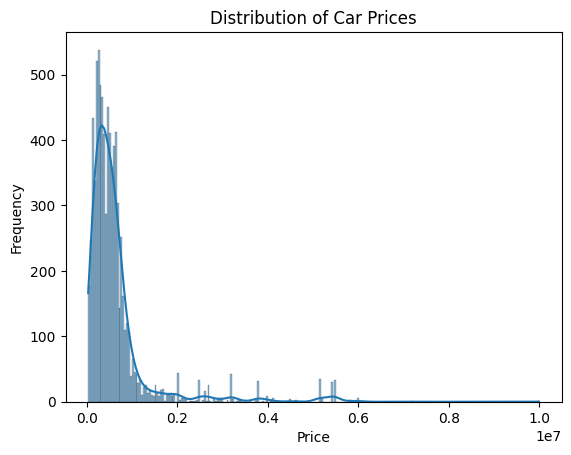

In [100]:
sns.histplot(df.selling_price, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='selling_price', ylabel='Count'>

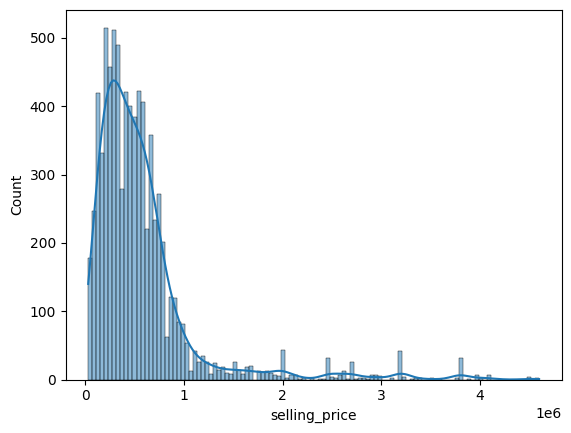

In [101]:
# Long tail distribution needs to be handled
sns.histplot(df.selling_price[df.selling_price < 5000000], kde=True)

In [102]:
np.log1p([0,1,10,1000,100000])

array([ 0.        ,  0.69314718,  2.39789527,  6.90875478, 11.51293546])

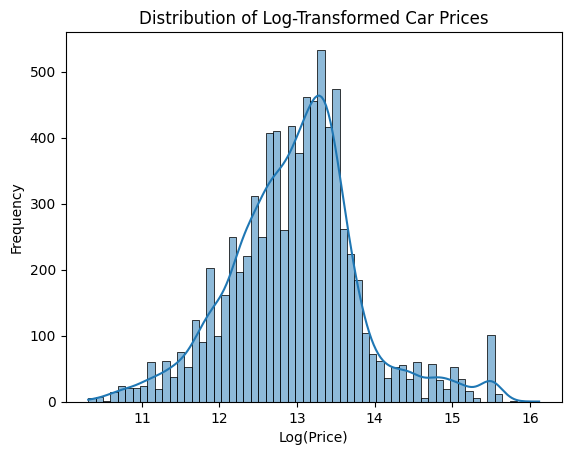

In [103]:
# Apply log transformation to reduce long tail effect
price_in_log = np.log1p(df.selling_price)
sns.histplot(price_in_log, kde=True)
plt.title('Distribution of Log-Transformed Car Prices')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

Before the log transformation, car prices are usually right-skewed (lots of cheaper cars, few very expensive ones).

After applying log(price), the distribution becomes much closer to normal (bell-shaped) distribution.

# 3 & 4. Feature Selection & Preprocessing

• Since selling price is a big number, it can cause your prediction to be very unstable. One trick
is to first transform the label using log transform, i.e.,
```
y = np.log(df['selling_price'])
```

• During inference/testing, you have to transform your predicted y backed before comparing with y
test, i.e.,
```
pred_y = np.exp(pred_y)
```

In [104]:
print("Number of null values in selling_price:", df['selling_price'].isnull().sum())
# since there's no null values in selling_price, we can safely create log_price column 
# (safely scaling performed)
df['log_price'] = np.log1p(df.selling_price)
df.head()


Number of null values in selling_price: 0


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,owner_num,mileage_num,engine_num,max_power_num,brand,log_price
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,5.0,1,23.40,1248.0,74.00,Maruti,13.017005
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,5.0,2,21.14,1498.0,103.52,Skoda,12.821261
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,5.0,3,17.70,1497.0,78.00,Honda,11.970357
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,5.0,1,23.00,1396.0,90.00,Hyundai,12.323860
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,5.0,1,16.10,1298.0,88.20,Maruti,11.775297


In [105]:
# Missing values for each column and sort descending
df.isnull().sum().sort_values(ascending=False)

engine           214
engine_num       214
mileage_num      214
seats            214
mileage          214
max_power        208
max_power_num    208
brand              0
owner_num          0
name               0
year               0
owner              0
transmission       0
seller_type        0
fuel               0
km_driven          0
selling_price      0
log_price          0
dtype: int64

4 columns has null values - Engine, Mileage, Seats, Torque(removed) , Max Power has null values

In [106]:
print(df.columns)

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats',
       'owner_num', 'mileage_num', 'engine_num', 'max_power_num', 'brand',
       'log_price'],
      dtype='object')


In [107]:

imputing_columns = df.columns[df.isnull().sum() > 0]
# expected 4 coulumns
imputing_columns = [x for x in imputing_columns.tolist() if not x.endswith('_num')]
print("Imputing columns: ", imputing_columns)


Imputing columns:  ['mileage', 'engine', 'max_power', 'seats']


before removing null values: 214


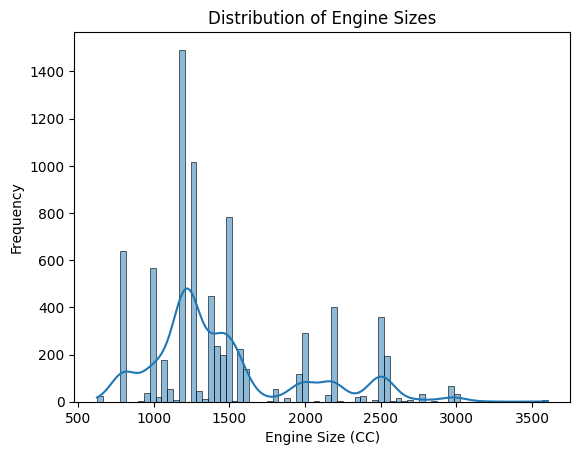

In [108]:
# Checking distribution of null values in Engine column
print(f"before removing null values:", df['engine'].isnull().sum())
sns.histplot(df['engine_num'].dropna(), kde=True)
plt.title('Distribution of Engine Sizes')
plt.xlabel('Engine Size (CC)')
plt.ylabel('Frequency')
plt.show()

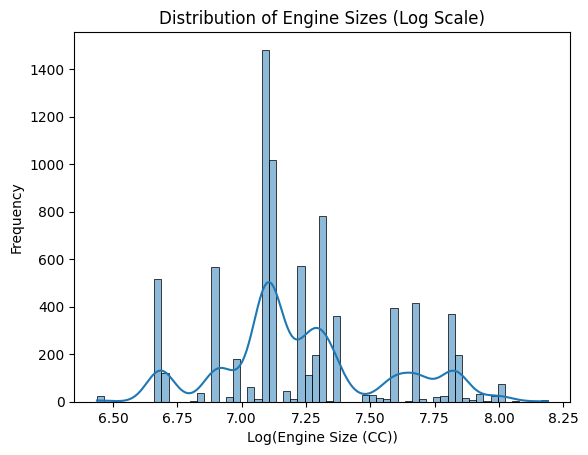

In [109]:
# Checking distribution of null values in Engine column
sns.histplot(np.log1p(df['engine_num'].dropna()), kde=True)
plt.title('Distribution of Engine Sizes (Log Scale)')
plt.xlabel('Log(Engine Size (CC))')
plt.ylabel('Frequency')
plt.show()


> Engine size distribution is skewed, imputation will be done with median value

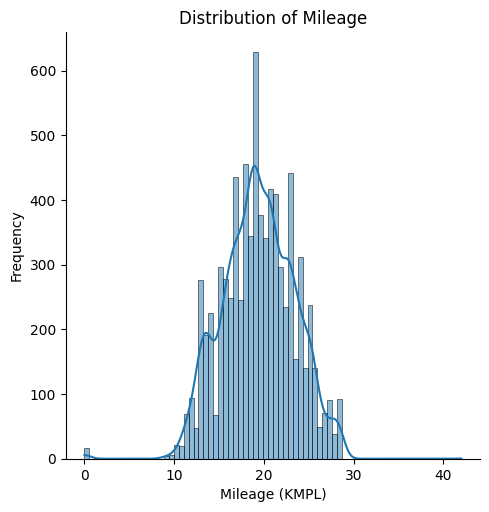

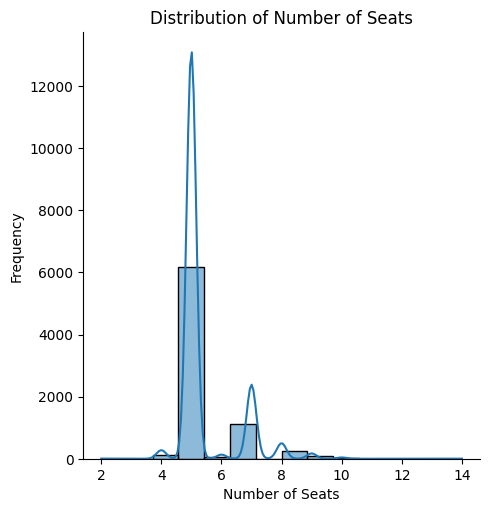

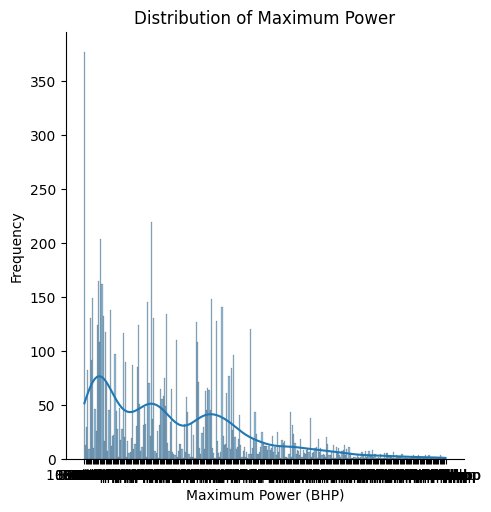

In [110]:
sns.displot(data = df, x = 'mileage_num', kde=True) # normalized
plt.title('Distribution of Mileage')
plt.xlabel('Mileage (KMPL)')
plt.ylabel('Frequency')
plt.show()

sns.displot(data = df, x = 'seats', kde=True) #has long tail
plt.title('Distribution of Number of Seats')
plt.xlabel('Number of Seats')
plt.ylabel('Frequency')
plt.show()

sns.displot(data = df, x = 'max_power', kde=True) #has long tail
plt.title('Distribution of Maximum Power')
plt.xlabel('Maximum Power (BHP)')
plt.ylabel('Frequency')
plt.show()

# sns.displot(data = df, x = 'torque') # --- IGNORE ---

In [111]:
# Distribution is skewed, so we will impute with median value
imputing_median_columns = ['engine', 'mileage', 'seats', 'max_power']

In [112]:
# The null values content is less than 10%, removing engine with null values
# print(f"before removing null values:", df['engine_num'].isnull().sum())
# df = df.dropna(subset=['engine_num'])
# print(f"after removing null values:", df['engine_num'].isnull().sum())
# Let's not drop rows with null values for now, we will impute them later.
#  The efficiency of the model is 77% with rows dropped for null values

In [113]:
# Check if there are any remaining null values in the dataset
print("Total", df.isnull().sum().sum())
print(df.isnull().sum().sort_values(ascending=False))
# There will be null values as we have not dropped any rows with null values


Total 1486
engine           214
engine_num       214
mileage_num      214
seats            214
mileage          214
max_power        208
max_power_num    208
brand              0
owner_num          0
name               0
year               0
owner              0
transmission       0
seller_type        0
fuel               0
km_driven          0
selling_price      0
log_price          0
dtype: int64


In [114]:
selected_columns = ['brand', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner_num', 'mileage_num', 'engine_num', 'max_power_num', 'seats']
#selected df with remaned columns only
sdf = df[selected_columns].rename(columns={
    'owner_num': 'owner',
    'mileage_num': 'mileage',
    'engine_num': 'engine',
    'max_power_num': 'max_power'
})
sdf.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0


In [115]:
# expected rows after removing null values = 8028 - 214 = 7814
sdf.shape

(8028, 12)

# 5. Feature Selection (EDA continued)

Finding relationship of Xs with selling_price (here with log value of selling price)
1. **km_driven vs selling_price:** 
2. **year vs selling_price:** 
3. **engine vs selling_price:** 
4. **max_power vs selling_price:** 

<Axes: xlabel='year', ylabel='selling_price'>

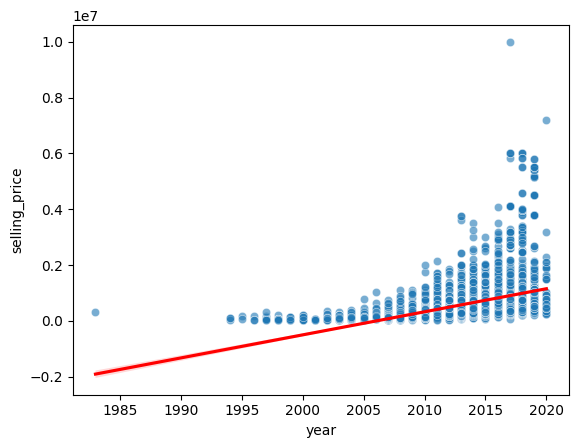

In [116]:
# Visualizing the relationship between features and target variable
# All features = ['brand', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
# numerical_features = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
selected_feature = 'year'
target_variable = 'selling_price'
sns.scatterplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        alpha=0.6
    )
sns.regplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        scatter=False,
        line_kws={"color": "red"}
    )
# Result is linear relationship

<Axes: xlabel='km_driven', ylabel='selling_price'>

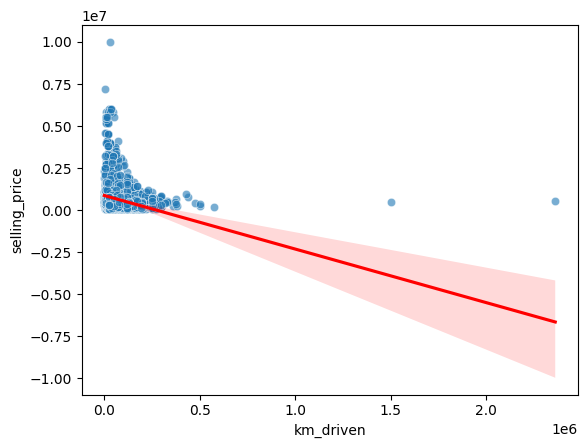

In [117]:
# All features = ['brand', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
# numerical_features = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
selected_feature = 'km_driven'
target_variable = 'selling_price'
sns.scatterplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        alpha=0.6
    )
sns.regplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        scatter=False,
        line_kws={"color": "red"}
    )

# Result is negative linear relationship, higher the km_driven, lower the selling_price

<Axes: xlabel='mileage', ylabel='selling_price'>

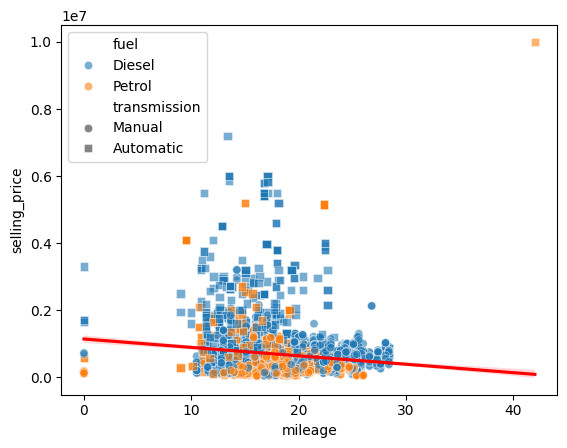

In [118]:
# All features = ['brand', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
# numerical_features = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
selected_feature = 'mileage'
target_variable = 'selling_price'
sns.scatterplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        alpha=0.6,
        hue='fuel',
        style='transmission',
        markers=['o', 's']
    )
sns.regplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        scatter=False,
        line_kws={"color": "red"}
    )


### Observations:
1. As the kilometres driven increases, the selling price tends to decrease, showing a negative correlation between these variables.
2. The variance in price is not constant across different kilometre values - there's more price variability among lower-kilometre cars than higher-kilometre cars.
3. There appears to be some clustering of data points, particularly in the lower kilometre ranges, suggesting price is affected by other factors such as brand, model, and year of manufacture.
4. There are some outliers visible - particularly some high-priced cars despite relatively high kilometre readings, which might represent luxury or collector vehicles.

In [119]:
# label encoder for non numeric values
# All features = ['brand', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
from sklearn.preprocessing import LabelEncoder

non_numeric_cols = ['brand', 'fuel', 'seller_type', 'transmission']
le = LabelEncoder()
for col in non_numeric_cols:
    sdf[col] = le.fit_transform(sdf[col])  

print(sdf.dtypes)
sdf.head()

brand              int64
year               int64
selling_price      int64
km_driven          int64
fuel               int64
seller_type        int64
transmission       int64
owner              int64
mileage          float64
engine           float64
max_power        float64
seats            float64
dtype: object


,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,20,2014,450000,145500,0,1,1,1,23.40,1248.0,74.00,5.0
1,27,2014,370000,120000,0,1,1,2,21.14,1498.0,103.52,5.0
2,10,2006,158000,140000,1,1,1,3,17.70,1497.0,78.00,5.0
3,11,2010,225000,127000,0,1,1,1,23.00,1396.0,90.00,5.0
4,20,2007,130000,120000,1,1,1,1,16.10,1298.0,88.20,5.0


<Axes: >

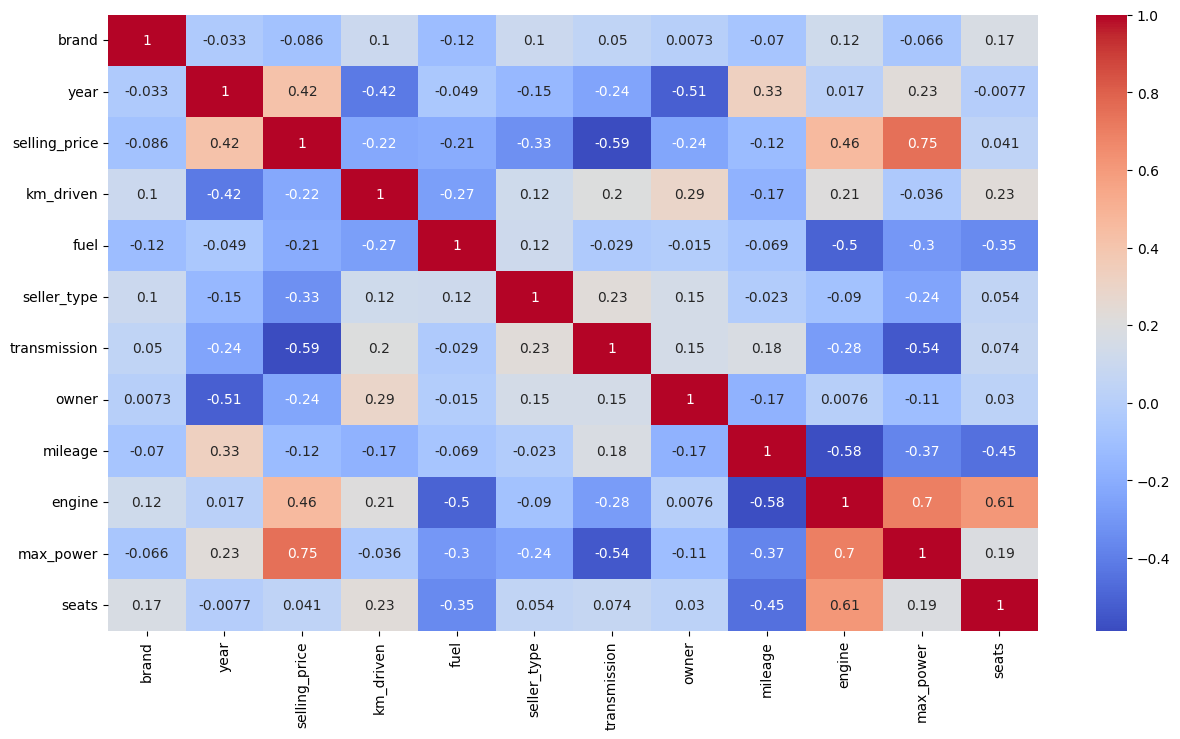

In [120]:
# EDA - Correlation matrix 
plt.figure(figsize = (15,8))
sns.heatmap(sdf.corr(), annot=True, cmap="coolwarm")


~~From Heatmap infers that selling_price has strong corellation with features **max_power, year and engine** in descending order~~ Crossing out because this is random approach.

The proper way is to check selling_price row or column and checking correlation value for all features. For this instance, taking all features with correlation value above absolute .30

List for selected correlated features: **year, seller_type, transmission, engine, max_power**


In [121]:
# Feature Selection:
# Target or y or dependent variable or label
y = sdf["selling_price"]
# Perform log scaling to speed up model training
y = np.log(sdf['selling_price'])
# Independent variables, or X or features or predictors or explanatory variables
features = ['year', 'seller_type', 'transmission', 'engine', 'max_power']
X = sdf[features]
y.head()

0    13.017003
1    12.821258
2    11.970350
3    12.323856
4    11.775290
Name: selling_price, dtype: float64

EDA for added features according to heat map analysis,
1. **max_power vs selling_price:** (Correlation value = 0.75)
2. **transmission vs selling_price:** (Correlation value = 0.59)
2. **engine vs selling_price:** (Correlation value = 0.46)
4. **year vs selling_price:** (Correlation value = 0.42)(Done it has positive correlation)
5. **seller_type vs selling_price:** (Correlation value = -0.33)

<Axes: xlabel='max_power', ylabel='selling_price'>

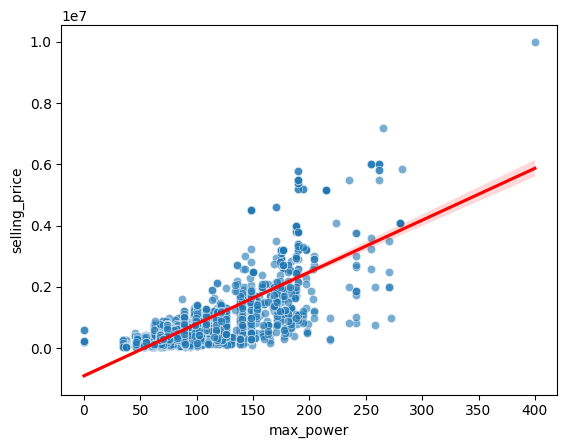

In [122]:
selected_feature = 'max_power'
target_variable = 'selling_price'
sns.scatterplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        alpha=0.6
    )
sns.regplot(
        x=selected_feature,
        y=target_variable,
        data=sdf,
        scatter=False,
        line_kws={"color": "red"}
    )


<Axes: xlabel='transmission', ylabel='selling_price'>

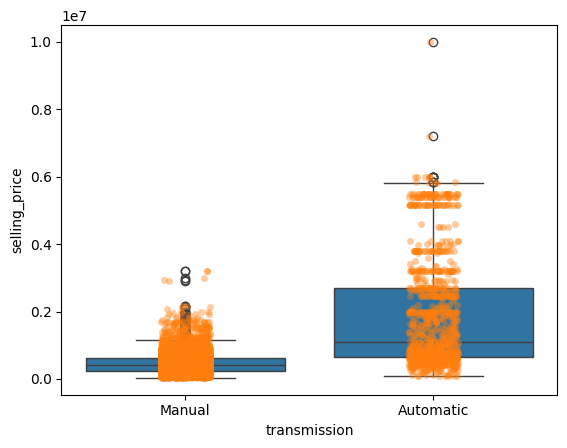

In [123]:
# Transmission vs selling_price
# Transmission has 2 values - Manual and Automatic ie. it's a categorical variable
sns.boxplot(data=df, x='transmission', y='selling_price')
# sns.violinplot(data=df, x='transmission', y='selling_price', cut=0)
# sns.stripplot(data=df, x='category_col', y='numeric_col', alpha=0.4, jitter=True)
sns.stripplot(data=df, x='transmission', y='selling_price', alpha=0.4, jitter=True)

Box + strip plot for transmission vs selling_price:

- If you used a box plot: it compares the selling price distributions for each transmission.
  - Median line: typical price in each group.
  - Box (IQR): spread of middle 50% of prices; taller box = more variability.
  - Whiskers/dots: range and outliers (very cheap/expensive cars).
  - Interpretation: If Automatic’s median > Manual’s and boxes overlap little, automatics generally sell higher. Many high outliers suggest a few premium automatic cars.

- If you overlaid a strip/stripplot: each dot is a car.
  - Dot density shows where most prices lie.
  - Gaps show rare price ranges.
  - Interpretation: A denser band at higher prices for a transmission indicates more cars selling in that higher range.

- What to conclude:
  - Check median difference (location shift) → “which costs more on average?” Automatic
  - Check spread (IQR/whiskers) → “which varies more?” Automatic
  - Note outliers → “are a few luxury models driving the tail?” Automatic luxury models tail up higher

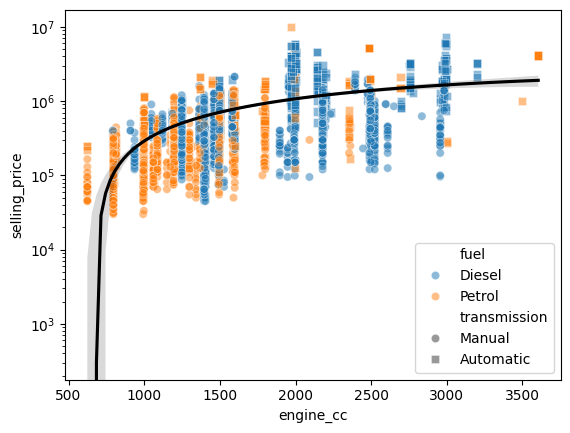

In [124]:
# selected_feature = 'engine'
# target_variable = 'selling_price'
# sns.scatterplot(
#         x=selected_feature,
#         y=target_variable,
#         data=sdf,
#         alpha=0.6
#     )
# sns.regplot(
#         x=selected_feature,
#         y=target_variable,
#         data=sdf,
#         scatter=False,
#         line_kws={"color": "red"}
#     )

# style='transmission',
#         markers=['o', 's']
# Clean engine and plot with trend
df['engine_cc'] = pd.to_numeric(df['engine'].str.replace('[^0-9.]','', regex=True))
sns.scatterplot(data=df, x='engine_cc', y='selling_price', hue='fuel', style='transmission', markers=['o', 's'], alpha=0.5)
sns.regplot(data=df, x='engine_cc', y='selling_price', scatter=False, order=2, color='k')
plt.yscale('log')  # optional, to stabilize variance

- Positive trend: Larger engine sizes often correlate with higher selling prices.
- Nonlinearity: Gains may taper at high engine sizes (diminishing returns).
- Heteroscedasticity: Price spread usually widens for bigger engines.
- Clusters: Different brands/fuel types form bands; color by category to see this. Transmission (manual or automatic)and fuel (Diesel and Petrol) makes difference in selling price 
- Outliers: Luxury/performance cars sit far above the trend.
- Data prep: Ensure `engine` is numeric (e.g., strip “CC”) and consider log-scaling price.

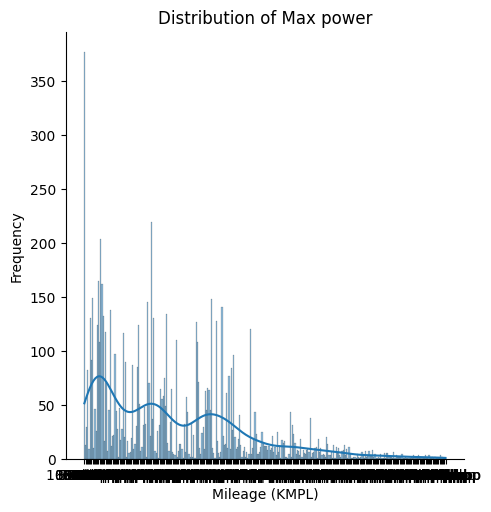

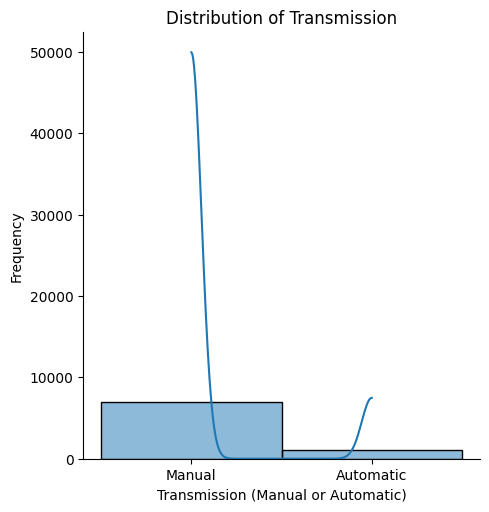

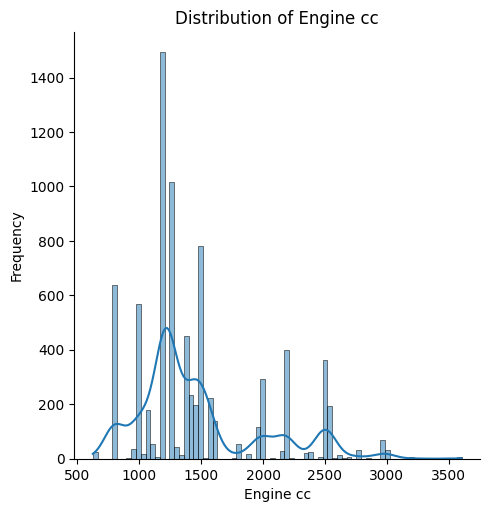

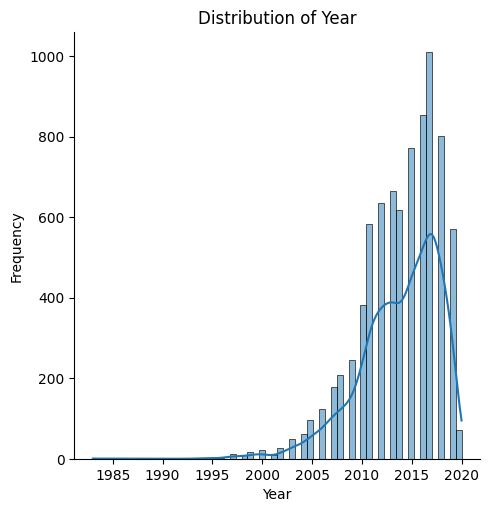

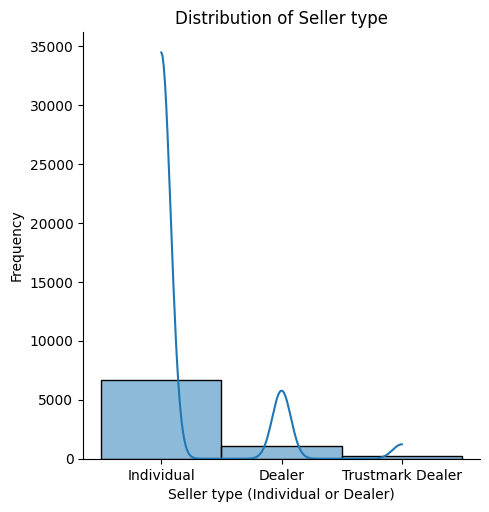

In [125]:
sns.displot(data = df, x = 'max_power', kde=True) # normalized
plt.title('Distribution of Max power')
plt.xlabel('Mileage (KMPL)')
plt.ylabel('Frequency')
plt.show()

sns.displot(data = df, x = 'transmission', kde=True) #has long tail
plt.title('Distribution of Transmission')
plt.xlabel('Transmission (Manual or Automatic)')
plt.ylabel('Frequency')
plt.show()

sns.displot(data = df, x = 'engine_cc', kde=True) #has long tail
plt.title('Distribution of Engine cc')
plt.xlabel('Engine cc')
plt.ylabel('Frequency')
plt.show()

sns.displot(data = df, x = 'year', kde=True) #has long tail
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

sns.displot(data = df, x = 'seller_type', kde=True) #has long tail
plt.title('Distribution of Seller type')
plt.xlabel('Seller type (Individual or Dealer)')
plt.ylabel('Frequency')
plt.show()

After analysing the plots and distribution, imputing by median is best and easier. Seller_type show the distribution is normalized for Dealer. For sake of convenience, seller_type will be imputed using median too.

# 6. Model Selection - Linear Regresssion
 During inference/testing, you have to transform your predicted y backed before comparing with y
test, i.e.,

In [126]:
from sklearn.model_selection import train_test_split
backup_sdf = sdf.copy()
print(f"Total dataset: {len(sdf)}")

#Splitting the data into train and test set => 70/30%
# Split only rows with no nulls in X
mask_clean = X.notnull().all(axis=1)
X_clean = X[mask_clean]
y_clean = y[mask_clean]

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=RANDOM_SEED)

# Find rows with any nulls in X
mask_null = ~mask_clean
X_null = X[mask_null]
y_null = y[mask_null]

# Add null rows to training set only
X_train = pd.concat([X_train, X_null])
y_train = pd.concat([y_train, y_null])

print(f"Train set: {len(X_train)} samples (may have nulls)")
print(f"Test set: {len(X_test)} samples (no nulls)")

Total dataset: 8028
Train set: 5683 samples (may have nulls)
Test set: 2345 samples (no nulls)


In [127]:
len(X_train), len(X_test), len(y_train), len(y_test)

(5683, 2345, 5683, 2345)

#### The training set contains null values, which are being imputed using the median since the distributions of all four columns with missing values are skewed. RATIO can be also used but kept it for later for improvement. Let sse how it works for median imputation.


In [128]:
print("List of features to impute by medians :", features)
medians = X_train[features].median(numeric_only=True)
X_train[features] = X_train[features].fillna(medians)
print("Null values in X_train features after imputation:", sdf[features].isnull().sum())

# print("Columns with null values", imputing_median_columns)
# print("X_train", X_train.head())
# #If single column, it's easier to do without loop
# # engine_median = sdf['engine'].median()
# # print("Median value of engine column:", engine_median)
# # # Fill up null values with median value
# # sdf['engine'].fillna(engine_median, inplace=True)
# # print("Null values in engine column:", sdf['engine'].isnull().sum())
# for col in imputing_median_columns:
#     col_median = X_train[col].median()
#     print(f"\nMedian value of {col} column:", col_median)
#     print(f"Null values in {col} column before imputation:", X_train[col].isnull().sum())
#     # Fill up null values with median value
#     X_train[col].fillna(col_median, inplace=True)
#     print(f"Null values in {col} column after imputation:", X_train[col].isnull().sum())


List of features to impute by medians : ['year', 'seller_type', 'transmission', 'engine', 'max_power']
Null values in X_train features after imputation: year              0
seller_type       0
transmission      0
engine          214
max_power       208
dtype: int64


In [129]:
#importing all the regression models
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#our models and their names in the two lists respectively
algorithms = [LinearRegression(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(random_state = RANDOM_SEED), 
              RandomForestRegressor(n_estimators = 100, random_state = RANDOM_SEED)]

# Model selection
algorithm_names = ["Linear Regression", "SVR", "KNeighbors Regressor", "Decision-Tree Regressor", "Random-Forest Regressor"]

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Use KFold and split into 5 subsets , and 1 will be used as validation set
kfold = KFold(n_splits=5, shuffle=True)

# scoring: metric name or callable (e.g., 'r2', 'neg_mean_squared_error', 'accuracy')
# r2: Coefficient of determination (1 is perfect, 0 means baseline, can be negative).
# neg_mean_squared_error: Negative MSE. Larger (less negative) is better. MSE = mean((y - ŷ)^2).
# neg_root_mean_squared_error: Negative RMSE. Larger (less negative) is better. RMSE = sqrt(MSE).
# neg_mean_absolute_error: Negative MAE. Larger (less negative) is better. MAE = mean(|y - ŷ|).
# explained_variance: Fraction of variance explained by predictions (0–1, higher is better).

# Evaluate each model using cross-validation for single score metric
# for i, model in enumerate(algorithms):
#     scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)
#     print(f"{algorithm_names[i]:<25} - Score: {scores}; Neg Mean: {scores.mean()}")

from sklearn.model_selection import cross_validate

for i, model in enumerate(algorithms):
    results = cross_validate(
        model,
        X_train,
        y_train,
        scoring=['neg_mean_squared_error', 'r2'],
        cv=kfold,
        return_train_score=False
    )
    print(f"{algorithm_names[i]:<25} - NMSE: {results['test_neg_mean_squared_error']}; Mean NMSE: {results['test_neg_mean_squared_error'].mean():.5f}")
    print(f"{algorithm_names[i]:<25} - R2: {results['test_r2']}; Mean R2: {results['test_r2'].mean():.5f}")

#since we are using NMSE, smaller number is better and thus the best model shown below is Random Forest Regression Model of = -0.00033 value(first iteration)
# second iteration: 0.059378571672877654 (after imputing null values)
# adding R2 score as well shows that Random Forest is the best model with R2 = 0.92 (Closer the value to 1 , better the model)

Linear Regression         - NMSE: [-0.11026876 -0.10179574 -0.09825765 -0.110853   -0.11005368]; Mean NMSE: -0.10625
Linear Regression         - R2: [0.84872147 0.8556705  0.86128276 0.83545953 0.85834971]; Mean R2: 0.85190
SVR                       - NMSE: [-0.36065787 -0.35178247 -0.36481171 -0.37158696 -0.36390736]; Mean NMSE: -0.36255
SVR                       - R2: [0.47928914 0.49681653 0.49273445 0.50153384 0.50436641]; Mean R2: 0.49495
KNeighbors Regressor      - NMSE: [-0.06832958 -0.06559836 -0.06642716 -0.07443116 -0.07991035]; Mean NMSE: -0.07094
KNeighbors Regressor      - R2: [0.91146966 0.90784075 0.90426374 0.89687201 0.8845764 ]; Mean R2: 0.90100
Decision-Tree Regressor   - NMSE: [-0.07810995 -0.0633123  -0.07203504 -0.06703562 -0.08248356]; Mean NMSE: -0.07260
Decision-Tree Regressor   - R2: [0.88640179 0.90339306 0.90348552 0.90817742 0.89344892]; Mean R2: 0.89898
Random-Forest Regressor   - NMSE: [-0.06521654 -0.06677656 -0.05673206 -0.057725   -0.04940492]; Mean NM

In [ ]:
#Find the best Random-Forest Regressor model
from sklearn.model_selection import GridSearchCV

param_grid = { 'max_depth': [5, 10, None],
              'n_estimators': [5, 25, 40, 55, 70, 85, 100, 150, 200],
              }

# keeping random_state for fixed
rf = RandomForestRegressor(random_state=RANDOM_SEED) 

grid = GridSearchCV(estimator = rf, 
                    param_grid = param_grid, 
                    cv = kfold, 
                    n_jobs = -1, 
                    return_train_score=True, 
                    refit=True,
                    scoring='neg_mean_squared_error') 
# if multiple metrics are needed, 
# use scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'} - Sushmi to check - list or tuple can be passed

# Fit your grid_search
grid.fit(X_train, y_train);  #fit means start looping all the possible parameters

In [132]:
# Use the best model to predict on test set
best_mse = grid.best_score_
print("The best NMSE that we can get with Random Forest is:", best_mse, "\nwith parameters:", grid.best_params_)
grid.best_estimator_


The best NMSE that we can get with Random Forest is: -0.057616071006661086 
with parameters: {'max_depth': None, 'n_estimators': 200, 'random_state': 42}


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 7. Testing

In [133]:
yhat = grid.predict(X_test)
print("Thus, our model's NMSE score when applied on the test dataset is:", mean_squared_error(y_test, yhat))

Thus, our model's NMSE score when applied on the test dataset is: 0.04614113483711169


# 8. Analysis

In [134]:
#in ML some algorithms give better feature importance after the model is fitted which is in best_estimator_
best_rf = grid.best_estimator_
best_rf.feature_importances_

array([0.48704358, 0.00379961, 0.00340546, 0.08024371, 0.42550764])

<BarContainer object of 5 artists>

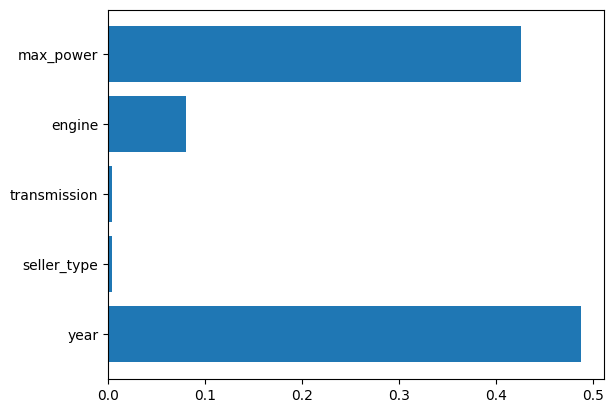

In [135]:
#plotting the weight in graph
plt.barh(X.columns, best_rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

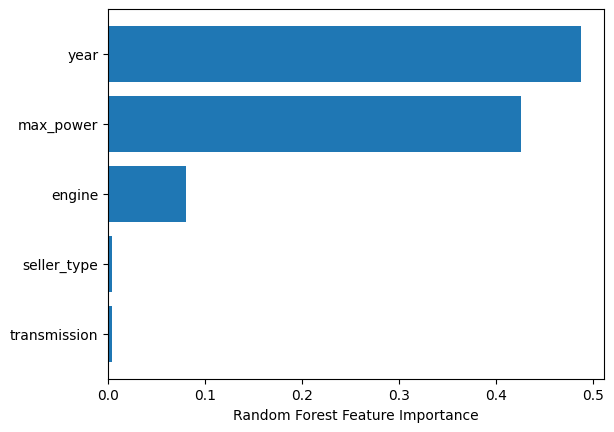

In [136]:
#sorting them for better view in ascending order of y-axis
sorted_idx = best_rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

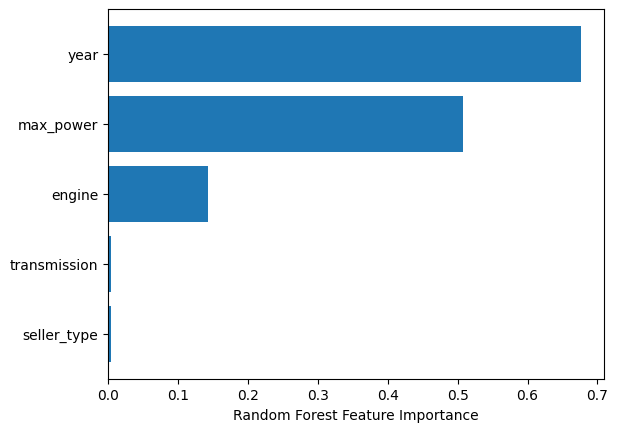

In [137]:
# Finding out which features impact the model the most via permutation way

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_rf, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [138]:
# Utilizing shap method this way around
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

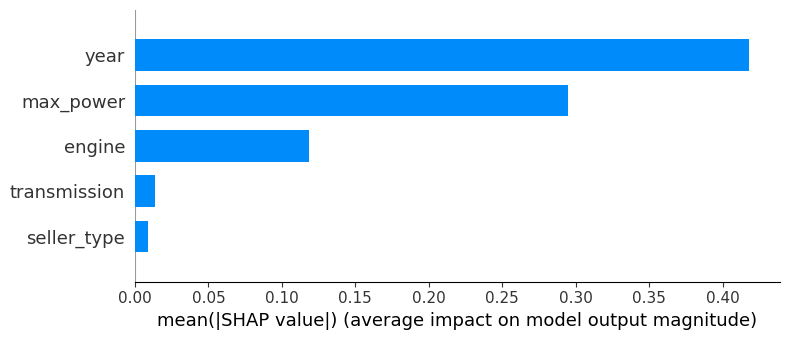

In [139]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = X.columns)

Max_power has highest correlation with selling_price previously, however year has highest correlation score of ~0.75. The ordering has been changed as year, max_power and engine.

**Follow up question: Why max_power is no longer the highest correlated feature with selling_price?**

# 9. Inference

In [140]:
#saving model to folder before using it for inference for later use
import pickle

filename = '../models/a1_predict_car_price.model'
pickle.dump(grid, open(filename, 'wb'))



In [141]:
# Pickle is for Python only, if you want to use the model in other languages or platforms, consider using ONNX format.
#saving in onnx file format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

onnx_filename = '../models/a1_predict_car_price.onnx'
best_model = grid.best_estimator_

initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(best_model, initial_types=initial_type)
with open(onnx_filename, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [142]:
# load the pickled model from disk
loaded_model = pickle.load(open(filename, 'rb'))

# load the ONNX model from disk
# import onnxruntime as ort
# loaded_model = ort.InferenceSession('../models/a1_predict_car_price.onnx')
# TODO : fix the onnx model loading and inference

In [143]:
#Take one sample
X_test.iloc[0]

year            2020.0
seller_type        1.0
transmission       1.0
engine          1196.0
max_power         73.0
Name: 2690, dtype: float64

In [144]:
y_test.iloc[0], np.exp(y_test.iloc[0])  #actual value in log scale


(np.float64(12.936033799212835), np.float64(414999.9999999997))

In [145]:
X_test.dtypes

year              int64
seller_type       int64
transmission      int64
engine          float64
max_power       float64
dtype: object

In [152]:
print ("Log Scaled Y predicted vs actual: Y predicted vs actual")
diffs = [] # to store percentage diffs
for idx, row in X_test.iterrows():
    sample = row.values.reshape(1, -1)  # shape (1, n_features) for prediction
    log_pred_y = loaded_model.predict(sample) #predicts with best estimator
    
    # print("Log Scaled Y predicted vs actual:", log_pred_y, ",", y_test.loc[idx])
    pred_y = np.exp(log_pred_y)  #reverting the logarithmic scaling
    y = np.exp(y_test.loc[idx])

    """ 
    Extract scalar values for formatting
    This line ensures that pred_y_scalar is a plain Python float, not a NumPy array or other object.
    If pred_y is a NumPy array or similar (e.g., array([12345.6])), 
    .item() extracts the single value as a float (12345.6).
    If pred_y is already a float, it just uses float(pred_y).
    Purpose: 
        Guarantees you have a single float value for formatting or calculations, 
        regardless of the type returned by the model’s predict() method.
    """
    pred_y_scalar = pred_y.item() if hasattr(pred_y, "item") else float(pred_y)
    y_scalar = y.item() if hasattr(y, "item") else float(y)
    diff = ((pred_y_scalar - y_scalar) / y_scalar) ** 2
    diffs.append(diff)
    print(f"({log_pred_y[0]:10.5f}, {y_test.loc[idx]:10.5f}) ({pred_y_scalar:10.2f}, {y_scalar:10.2f}) squared diff % {diff:3.2f}")


print(f"Average squared diff %: {np.mean(diffs):3.2f}, Std dev of squared diff %: {np.std(diffs):3.2f}")


Log Scaled Y predicted vs actual: Y predicted vs actual
(  12.92460,   12.93603) ( 410280.29,  415000.00) squared diff % 0.00
(  12.03108,   12.27839) ( 167893.45,  215000.00) squared diff % 0.05
(  13.06499,   13.14216) ( 472120.21,  509999.00) squared diff % 0.01
(  13.16867,   12.98310) ( 523695.60,  434999.00) squared diff % 0.04
(  13.71822,   13.62314) ( 907289.66,  825000.00) squared diff % 0.01
(  12.80149,   12.89922) ( 362758.22,  400000.00) squared diff % 0.01
(  12.96958,   13.14216) ( 429158.89,  509999.00) squared diff % 0.03
(  13.51293,   13.51441) ( 738909.90,  740000.00) squared diff % 0.00
(  13.39101,   13.42247) ( 654094.81,  675000.00) squared diff % 0.00
(  13.11350,   12.82126) ( 495589.94,  370000.00) squared diff % 0.12
(  12.18808,   12.50618) ( 196434.34,  270000.00) squared diff % 0.07
(  14.07867,   14.24078) (1301031.98, 1530000.00) squared diff % 0.02
(  13.75344,   13.95527) ( 939814.94, 1150000.00) squared diff % 0.03
(  13.21169,   13.12236) ( 546719.

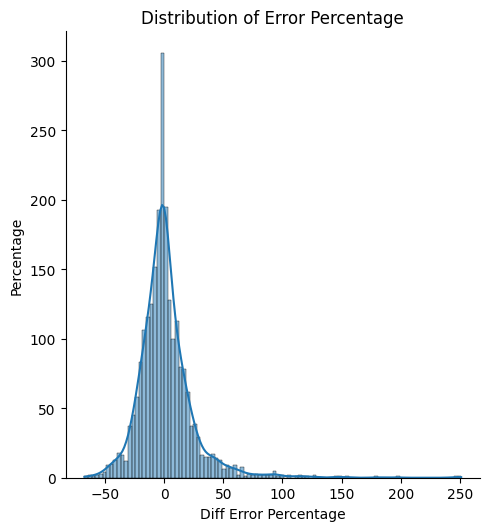

In [147]:
sns.displot(data = diffs, kde=True) #has long tail
plt.title('Distribution of Error Percentage')
plt.xlabel('Diff Error Percentage')
plt.ylabel('Percentage')
plt.show()

This means,

Average diff % (1.60):
On average, Random forest model predicted car prices are 1.6% higher than the actual prices in the test set. This is the mean percentage error across all test samples.

Std dev of diff % (24.06):
The standard deviation of the percentage differences is 24.06%, which shows there is a wide spread (variation) in how much individual predictions differ from the actual prices. Some predictions may be much higher or lower than the actual value.

Summary:
Your model is, on average, quite close to the true price (small bias), but individual predictions can vary a lot (high variability).

**Follow up question: How to remove or reduce standard deviation on error?**
**After diff is squared and calculated standard deviation, the mean squared error = 0.06 with standard deviation +/- 0.25**

# Task 2. Report  
In the end of the notebook, please write a 2-3 paragraphs summary deeply discussing and analysing the results. 
 Possible points of discussion: <br>
 **• Which features are important? Which are not? Why?** <br>

Based on the analysis, the most important features for predicting car prices are year, max_power, and engine. This is supported by both correlation analysis and feature importance scores from the Random Forest model and permutation importance.

- Year is the strongest predictor, likely because newer cars tend to have higher prices.
- Max_power and engine size also contribute significantly, as they reflect the car’s performance and specifications.
- Other features like transmission and seller_type are less important in this model, possibly because their effects are either captured indirectly by the main features or have less direct impact on price.


**• Which algorithm performs well? Which does not? Why? (here, you haven’t learned about any algorithms yet, but you can search online a bit and start building an intuition)** <br>

Among the tested algorithms, Random Forest Regressor performed best, achieving the lowest negative mean squared error (NMSE) in cross-validation. <br>

Random Forest works well because it can capture non-linear relationships and interactions between features.
Simpler models like Linear Regression may not perform as well due to the complex nature of car price prediction.
Algorithms like SVR, KNeighbors, and Decision Tree were also tested, but Random Forest’s ensemble approach provided better generalization and accuracy. <br>

**Theory behind Random Forest:**
> Random Forest is an ensemble machine learning algorithm used for both classification and regression tasks. It works by building multiple decision trees during training and combining their outputs to improve accuracy and reduce overfitting.

**How it works:** <br>
    - Trains many decision trees on random subsets of the data and features.<br>
    - Each tree makes a prediction.<br>
    - For regression, the final prediction is the average of all tree predictions.<br>
    - For classification, the final prediction is the majority vote.<br>
**Advantages:** <br>
    - Handles non-linear data well.<br>
    - Reduces overfitting compared to a single decision tree.<br>
    - Works with both numerical and categorical features.<br>
    - Provides feature importance scores.<br>
**Disadvantages:** <br>
    - Can be slower to predict than a single tree.<br>
    - Less interpretable than a single decision tree.<br>

**Summary:** <br>
   Random Forest is popular for its accuracy, robustness, and ability to handle complex datasets.<br>


# Future Enhancements
1. Use ONNX for model serialization - it is open standards with cross-platform interoperability feature
2. Seller_type and transmission has minimal to negligible importance. Also from correlation heatmap, transmission and seller_type are correlated. Perform another analysis by dropping the lowest important feature. It will generate model with similar accuracy